In [1]:
import matplotlib.pyplot as plt
import mdtraj as md
import torch
from loguru import logger
from omegaconf import OmegaConf
from tqdm import tqdm

from rocketshp import config
from rocketshp.datasets.mdcath import MDCathDataModule
from rocketshp.modeling.architectures import (
        FlexibilityModelWithTemperature,
)
from rocketshp.plot import display_trajectory

2025-01-16 13:32:18.127 | INFO     | rocketshp.config:<module>:13 - PROJ_ROOT path is: /mnt/home/ssledzieski/Projects/rocketshp
/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
config_file = "../configs/config.yml"
# checkpoint_file = fmnew = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split/model-epoch=14-train_loss=0.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=02-train_loss=2.68.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/revert_loss/model-epoch=17-train_loss=0.29.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/temperature_atlas/model-epoch=10-train_loss=0.36.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/mdcath_temp/model-epoch=00-train_loss=0.56.pt.ckpt"
checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/mdcath_temp_2/model-epoch=16-train_loss=0.30.pt.ckpt"

PARAMS = config.DEFAULT_PARAMETERS
PARAMS.update(OmegaConf.load(config_file))


In [3]:
adl = MDCathDataModule(config.PROCESSED_DATA_DIR / "mdcath/mdcath_processed.h5",
                      seq_features=True, struct_features=True,
                      batch_size=8, num_workers=PARAMS.num_data_workers,
                      train_pct=PARAMS.train_pct, val_pct=PARAMS.val_pct,
                      random_seed=PARAMS.random_seed, shuffle=PARAMS.shuffle,
                      )
adl.setup("train")
ads = adl.dataset
logger.info(f"{len(adl.dataset)}, {len(adl.train_data)}, {len(adl.val_data)}, {len(adl.test_data)}")

2025-01-16 13:32:23.844 | INFO     | __main__:<module>:9 - 129600, 101325, 12725, 15550


In [4]:
# model = FlexibilityModel.load_from_checkpoint(checkpoint_file, strict=False)
model = FlexibilityModelWithTemperature.load_from_checkpoint(checkpoint_file, strict=False)
# model = FlexibilityModelWithTemperature(
#         embedding_dim = PARAMS.embedding_dim,
#         output_dim = PARAMS.output_dim,
#         d_model = PARAMS.d_model,
#         n_heads = PARAMS.n_heads,
#         n_layers = PARAMS.n_layers,
#     )

/mnt/home/ssledzieski/Projects/rocketshp/rocketshp/modeling/architectures.py:310: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk = torch.load(checkpoint_path)


2025-01-16 13:32:24.151 | DEBUG    | __main__:<module>:13 - torch.Size([123, 1536]), torch.Size([123])
2025-01-16 13:32:24.211 | INFO     | __main__:<module>:39 - Protein: 4yl4A00/T379/R1


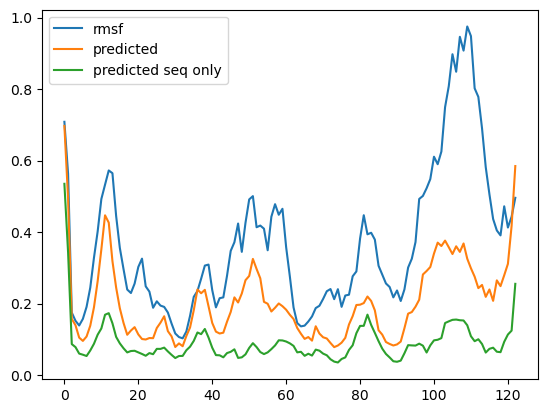

In [5]:
SAMPLE_I = 14

DATA_SUBSET = adl.test_data
# DATA_SUBSET = adl.val_data
# DATA_SUBSET = adl.train_data
SAMPLE_I = 15007
# SAMPLE_I = 121

feats, labels = DATA_SUBSET[SAMPLE_I]
key = adl.dataset.samples[DATA_SUBSET.indices[SAMPLE_I]]
temp = int(key.split("/")[1].lstrip("T"))

logger.debug(f'{feats["seq_feats"].shape}, {labels["rmsf"].shape}')

with torch.no_grad():
        both_result = model({k: v.unsqueeze(0) for k,v in feats.items()})
        feats["struct_feats"] = torch.zeros_like(feats["struct_feats"])
        seqonly_result = model({k: v.unsqueeze(0) for k,v in feats.items()})

        yhat_both = both_result["rmsf"]
        sqfm_both = both_result["ca_dist"]

        yhat_seqonly = seqonly_result["rmsf"]
        sqfm_seqonly = seqonly_result["ca_dist"]

bf_both = yhat_both.detach().cpu().numpy().squeeze()
bf_seqonly = yhat_seqonly.detach().cpu().numpy().squeeze()

plt.plot(labels["rmsf"],label="rmsf")
plt.plot(bf_both,label="predicted")
plt.plot(bf_seqonly,label="predicted seq only")
plt.legend()


# spearman = spearmanr(labels["rmsf"], bf_both)
# pearson = pearsonr(labels["rmsf"], bf_both)
# mse = ((labels["rmsf"] - bf_both)**2).mean()
logger.info(f"Protein: {key}")
# logger.info(f"Spearman: {spearman}")
# logger.info(f"Pearson: {pearson}")
# logger.info(f"MSE: {mse}")

plt.show()



In [6]:
pdb_code, temp, rep = key.split("/")
temp = temp.lstrip("T")
rep = rep.lstrip("R")
traj = md.load_xtc(config.PROCESSED_DATA_DIR  / f"mdcath/{pdb_code}/{pdb_code}_{temp}_{rep}.xtc", top=config.PROCESSED_DATA_DIR  / f"mdcath/{pdb_code}/{pdb_code}.pdb")
traj.superpose(traj, 0)
traj.center_coordinates()
view = display_trajectory(traj, bfactor=bf_both, coloring="bfactor", normalize=True, RMAX=2)
view

NGLWidget(max_frame=499)

---
## Variance of RMSF within different subsets of a trajectory

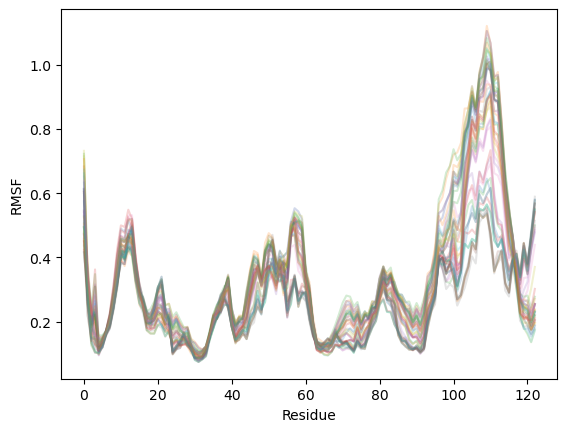

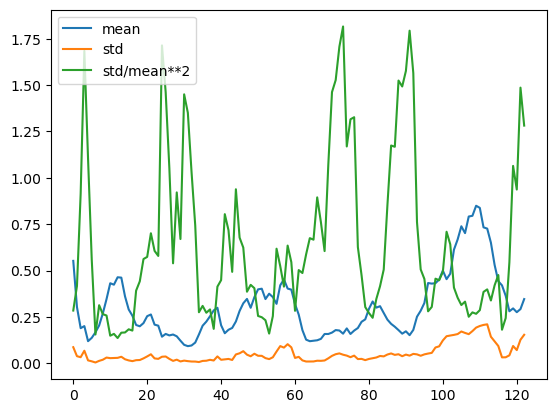

In [7]:
import numpy as np

subsample_rmsf = []
for _ in range(50):
    start = np.random.randint(0, traj.n_frames//2)
    stride = 5
    t_sub = traj[start:start+traj.n_frames//2:stride]
    sample = md.rmsf(t_sub, t_sub, 0, atom_indices=traj.top.select("name CA"))
    subsample_rmsf.append(sample)

subsample_rmsf = np.stack(subsample_rmsf)
import matplotlib.pyplot as plt

plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.T, alpha=0.2)
plt.xlabel("Residue")
plt.ylabel("RMSF")
plt.show()

plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.mean(axis=0),label="mean")
plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.std(axis=0),label="std")
plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.std(axis=0) / subsample_rmsf.mean(axis=0)**2, label="std/mean**2")

plt.legend()
plt.show()

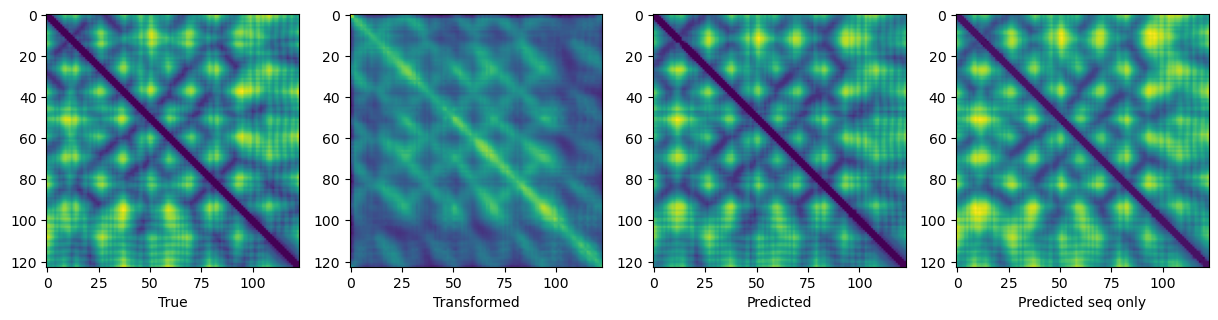

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(15, 10))

true_sqform = md.geometry.squareform(
                *md.compute_contacts(traj[0], scheme="ca", ignore_nonprotein=True)
            )
transform_sqform = model._cross_transform({k: v.unsqueeze(0) for k,v in feats.items()}).squeeze().detach().cpu().numpy()


ax[0].imshow(true_sqform.squeeze())
ax[0].set_xlabel("True")
ax[1].imshow(transform_sqform)
ax[1].set_xlabel("Transformed")
ax[2].imshow(sqfm_both.squeeze())
ax[2].set_xlabel("Predicted")
ax[3].imshow(sqfm_seqonly.squeeze())
ax[3].set_xlabel("Predicted seq only")
plt.show()

---

### Compare across  temperatures

In [17]:
import numpy as np

DATA_SUBSET = adl.test_data
BASE_SAMPLE_I = 15005
# BASE_SAMPLE_I = 15010
# BASE_SAMPLE_I = 0

all_results = []
residuals = []
for rep in [0,1,2,3,4]:
    SAMPLE_I = BASE_SAMPLE_I + rep

    feats, labels = DATA_SUBSET[SAMPLE_I]
    key = adl.dataset.samples[DATA_SUBSET.indices[SAMPLE_I]]
    logger.info(key)
    temp = int(key.split("/")[1].lstrip("T"))

    with torch.no_grad():
        both_result = model({k: v.unsqueeze(0) for k,v in feats.items()})
        yhat_both = both_result["rmsf"]
        bf_both = yhat_both.detach().cpu().numpy().squeeze()
        all_results.append( (yhat_both, bf_both) )
        residuals.append( np.abs(labels["rmsf"] - bf_both) )

2025-01-16 13:33:21.356 | INFO     | __main__:<module>:14 - 4yl4A00/T320/R1
2025-01-16 13:33:21.374 | INFO     | __main__:<module>:14 - 4yl4A00/T348/R1
2025-01-16 13:33:21.390 | INFO     | __main__:<module>:14 - 4yl4A00/T379/R1
2025-01-16 13:33:21.407 | INFO     | __main__:<module>:14 - 4yl4A00/T413/R1
2025-01-16 13:33:21.423 | INFO     | __main__:<module>:14 - 4yl4A00/T450/R1


In [18]:
pdb_code, temp, rep = key.split("/")
temp = temp.lstrip("T")
rep = rep.lstrip("R")
traj = md.load_xtc(config.PROCESSED_DATA_DIR  / f"mdcath/{pdb_code}/{pdb_code}_{temp}_{rep}.xtc", top=config.PROCESSED_DATA_DIR  / f"mdcath/{pdb_code}/{pdb_code}.pdb")
traj.superpose(traj, 0)
traj.center_coordinates()
view = display_trajectory(traj, bfactor=bf_both, coloring="bfactor", normalize=True, RMAX=2)
view

NGLWidget(max_frame=129)

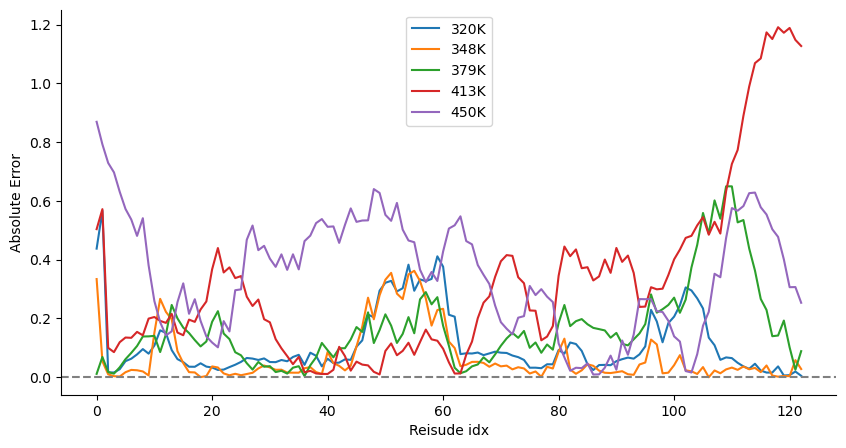

In [19]:
import seaborn as sns

temp_list = [320, 348, 379, 413, 450]

fig,ax = plt.subplots(1,1,figsize=(10,5))
for t, r in zip(temp_list, residuals):
    plt.plot(r, label=f"{t}K")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Reisude idx")
plt.ylabel("Absolute Error")
plt.legend()
sns.despine()
plt.show()

In [20]:
import pandas as pd

all_df = []
for t, r in zip(temp_list, residuals):
    tmpdf = pd.DataFrame(r, columns=["error"])
    tmpdf["temp"] = t
    tmpdf["residx"] = np.arange(len(r))
    tmpdf["resbin"] = pd.cut(tmpdf["residx"], bins=np.arange(0, 140, 10))
    all_df.append(tmpdf)
all_df = pd.concat(all_df)

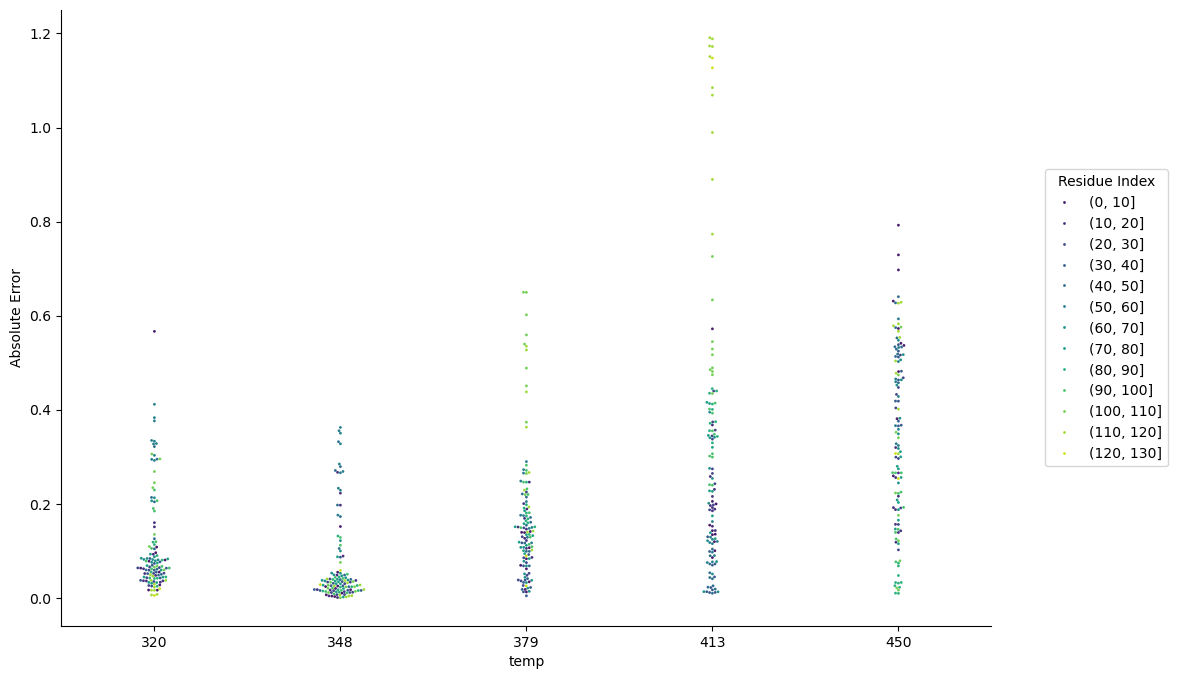

In [21]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.swarmplot(all_df, x="temp", y="error", hue="resbin", palette="viridis", s=2)
plt.ylabel("Absolute Error")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title="Residue Index")
sns.despine()
plt.show()

---

In [1]:
fb, yb, lb = next(iter(adl.train_dataloader()))

NameError: name 'adl' is not defined

In [8]:
tform = model._transform((fb["seq_feats"], fb["struct_feats"]))

In [9]:
tform.shape, fb["temp"].shape

(torch.Size([8, 184, 256]), torch.Size([8, 184]))

In [10]:
torch.cat([tform, fb["temp"].unsqueeze(-1)], dim=-1).shape

torch.Size([8, 184, 257])

In [11]:
predb = model((fb["seq_feats"], fb["struct_feats"]))

TypeError: tuple indices must be integers or slices, not str

In [40]:
predb["ca_dist"].shape,yb["ca_dist"].shape,predb["rmsf"].shape,yb["rmsf"].shape

(torch.Size([8, 415, 415]),
 torch.Size([8, 415, 415]),
 torch.Size([8, 415, 1]),
 torch.Size([8, 415]))

In [41]:
from rocketshp.modeling.pt_lightning import (
        compute_masked_mse_loss,
        compute_square_masked_mse_loss,
)

In [42]:
compute_masked_mse_loss(predb["rmsf"], yb["rmsf"].unsqueeze(-1), lb, rmse=True)

tensor(0.0748, grad_fn=<SqrtBackward0>)

In [43]:
compute_square_masked_mse_loss(predb["ca_dist"], yb["ca_dist"], lb, rmse=True)

tensor(3.0609, grad_fn=<SqrtBackward0>)

In [44]:
x = model._transform((fb["seq_feats"], fb["struct_feats"]))

In [46]:
sqform_tensor = model.squareformer((x.unsqueeze(1) * x.unsqueeze(2)).transpose(1,3)).squeeze()

In [49]:
sqform_tensor.shape, predb["ca_dist"].shape

(torch.Size([8, 415, 415]), torch.Size([8, 415, 415]))

## Testing Runtime

In [31]:
# Profile time it takes to run
import time

results = {}

start = time.time()
with torch.no_grad():
    for samp_i in tqdm(range(len(DATA_SUBSET))):
        feats, labels = DATA_SUBSET[SAMPLE_I]
        key = adl.dataset.samples[DATA_SUBSET.indices[SAMPLE_I]]
        temp = int(key.split("/")[1].lstrip("T"))


        both_result = model({k: v.unsqueeze(0) for k,v in feats.items()})
        results[key] = both_result
end = time.time()
print(f"Elapsed time: {end - start}")
print(f"Time per sample: {(end - start) / len(DATA_SUBSET)}")

100%|██████████| 15550/15550 [03:34<00:00, 72.43it/s]

Elapsed time: 214.69730806350708
Time per sample: 0.013806900840096918
